<a href="https://colab.research.google.com/github/yashrith/ModelForge/blob/main/project_AE_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import ops
from tensorflow.keras import Input, Model
from sklearn.metrics import roc_auc_score

In [ ]:
print(tf.__version__)

2.18.0


In [ ]:
# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

### Preprocessing

In [ ]:
def preprocess_data(x_train, x_test):
    # Normalize to [0,1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Reshape for CNN (add channel dimension)
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)

    # Add random noise for denoising AE
    noise_factor = 0.5
    x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

    # Clip values to stay in [0,1]
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)

    return x_train, x_test, x_train_noisy, x_test_noisy

In [ ]:
# Train only on class 0 (T-shirt/top)
train_class = 1
x_train_filtered = x_train[y_train == train_class]

# Test on class 7 (sneakers)
test_class = 7
x_test_filtered = x_test[y_test == test_class]

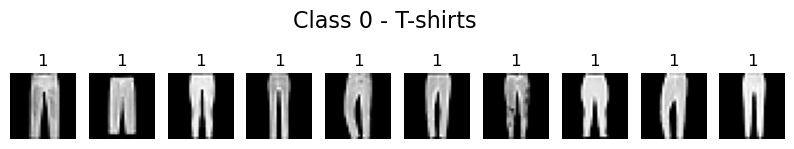

In [ ]:
# Display the first 10 images from the filtered training set
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train_filtered[i].squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(f"{train_class}")
plt.suptitle("Class 0 - T-shirts", fontsize=16)
plt.show()

### Build Convolutional Autoencoder model

In [ ]:
# Build Convolutional Autoencoder model
def build_conv_ae():
    # Encoder
    input_img = keras.layers.Input(shape=(28, 28, 1))

    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = keras.layers.UpSampling2D((2, 2))(x)
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.UpSampling2D((2, 2))(x)
    decoded = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.models.Model(input_img, decoded)
    return autoencoder

In [ ]:
# Data preprocessing
x_train, x_test, x_train_noisy, x_test_noisy = preprocess_data(x_train_filtered, x_test)

In [ ]:
# Vanilla AE
vanilla_ae = build_conv_ae()
vanilla_ae.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# Denoising AE
denoising_ae = build_conv_ae()
denoising_ae.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
print("Vanilla AE Summary:")
vanilla_ae.summary()
print("\nDenoising AE Summary:")
denoising_ae.summary()

Vanilla AE Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)


Denoising AE Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train models
batch_size = 128
epochs = 10

In [ ]:
# Train Vanilla AE
print("Training Vanilla AE...")
vanilla_history = vanilla_ae.fit(
    x_train, x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test),
    verbose=1
)

Training Vanilla AE...
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.5620 - val_loss: 0.4061
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.2203 - val_loss: 0.3502
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.2038 - val_loss: 0.3454
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.1985 - val_loss: 0.3422
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.1955 - val_loss: 0.3397
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.1925 - val_loss: 0.3382
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.1907 - val_loss: 0.3304
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.1883 - val_loss: 0.3296
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.1884 - val_loss: 0.3236
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.1870 - val_loss: 0.3230


In [ ]:
# Train Denoising AE
print("Training Denoising AE...")
denoising_history = denoising_ae.fit(
    x_train_noisy, x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_noisy, x_test),
    verbose=1
)

Training Denoising AE...
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 0.5860 - val_loss: 0.5017
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.2701 - val_loss: 0.4623
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.2297 - val_loss: 0.4102
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.2203 - val_loss: 0.4008
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.2148 - val_loss: 0.3986
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.2126 - val_loss: 0.3928
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.2101 - val_loss: 0.3954
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.2089 - val_loss: 0.3893
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.2075 - val_loss: 0.3877
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.2070 - val_loss: 0.3854


### to plot original, noisy, and reconstructed images


In [ ]:
# to plot original, noisy, and reconstructed images
def plot_reconstructions(original, noisy, vanilla_recon, denoised_recon, n=10):
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # Original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Noisy
        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Noisy')

        # Vanilla AE
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(vanilla_recon[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Vanilla AE')

        # Denoising AE
        ax = plt.subplot(4, n, i + 1 + 3*n)
        plt.imshow(denoised_recon[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Denoising AE')

    plt.show()

In [ ]:
# Get reconstructions
vanilla_reconstructed = vanilla_ae.predict(x_test)
denoised_reconstructed = denoising_ae.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


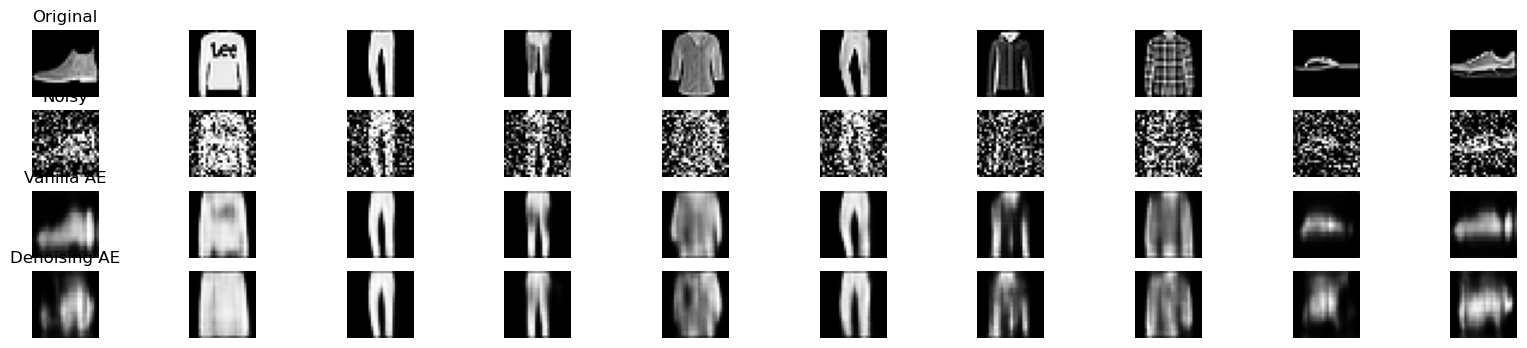

In [ ]:
# Plot results
plot_reconstructions(x_test, x_test_noisy, vanilla_reconstructed, denoised_reconstructed)

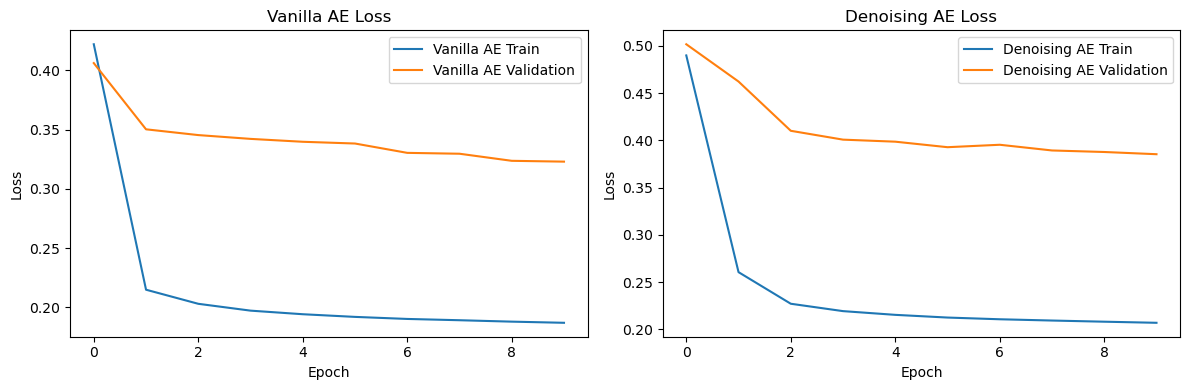

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(vanilla_history.history['loss'], label='Vanilla AE Train')
plt.plot(vanilla_history.history['val_loss'], label='Vanilla AE Validation')
plt.title('Vanilla AE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(denoising_history.history['loss'], label='Denoising AE Train')
plt.plot(denoising_history.history['val_loss'], label='Denoising AE Validation')
plt.title('Denoising AE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def compute_auroc(reconstruction_errors, true_labels, model_name="Model"):
    """
    Compute and print AUROC score for a given model.

    Parameters:
    - reconstruction_errors: np.array of error values
    - true_labels: binary labels (0 = normal, 1 = anomaly)
    - model_name: string name to print

    Returns:
    - AUROC score
    """
    auroc = roc_auc_score(true_labels, reconstruction_errors)
    print(f"{model_name} AUROC: {auroc:.4f}")
    return auroc


In [ ]:
# Compute errors
vanilla_errors = np.mean((x_test - vanilla_reconstructed) ** 2, axis=(1, 2, 3))

# Generate ground truth labels
true_labels = (y_test != 1).astype(int)  # 0 = trousers, 1 = anomaly

# Get AUROC score
vanilla_auroc = compute_auroc(vanilla_errors, true_labels, model_name="Vanilla AE")


Vanilla AE AUROC: 0.9702


In [ ]:
# Denoised AE
denoised_errors = np.mean((x_test - denoised_reconstructed) ** 2, axis=(1, 2, 3))
compute_auroc(denoised_errors, true_labels, model_name="Denoising AE")

Denoising AE AUROC: 0.9631


0.9630897777777778

### Anamoly detection and reconstructions

In [ ]:
# After predictions
vanilla_train_reconstructed = vanilla_ae.predict(x_train)
denoised_train_reconstructed = denoising_ae.predict(x_train_noisy)

# Reconstruction errors
vanilla_errors = np.mean((x_test - vanilla_reconstructed) ** 2, axis=(1, 2, 3))
denoised_errors = np.mean((x_test - denoised_reconstructed) ** 2, axis=(1, 2, 3))

# Thresholds (based on training data)
vanilla_thresh = np.mean(vanilla_train_errors) + 3 * np.std(vanilla_train_errors)
denoised_thresh = np.mean(denoised_train_errors) + 3 * np.std(denoised_train_errors)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [ ]:
# Compare with threshold
vanilla_anomalies = vanilla_errors > vanilla_thresh
denoised_anomalies = denoised_errors > denoised_thresh

print(f"Vanilla AE detected {np.sum(vanilla_anomalies)} anomalies out of {len(x_test)}")
print(f"Denoising AE detected {np.sum(denoised_anomalies)} anomalies out of {len(x_test)}")


Vanilla AE detected 6794 anomalies out of 10000
Denoising AE detected 6474 anomalies out of 10000


In [ ]:
def plot_anomalies(original, noisy, vanilla_recon, denoised_recon, vanilla_errors, denoised_errors,
                   vanilla_thresh, denoised_thresh, n=10):
    import matplotlib.pyplot as plt
    import numpy as np

    # Detect anomalies
    vanilla_anomalies = vanilla_errors > vanilla_thresh
    denoised_anomalies = denoised_errors > denoised_thresh

    # Find combined anomalies (either detected)
    combined_anomalies = np.logical_or(vanilla_anomalies, denoised_anomalies)
    anomaly_indices = np.where(combined_anomalies)[0][:n]  # Limit to n samples

    if len(anomaly_indices) == 0:
        print("No anomalies found based on current thresholds.")
        return

    # Plotting
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(anomaly_indices):
        # Original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(original[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Noisy
        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(noisy[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Noisy')

        # Vanilla AE
        ax = plt.subplot(4, n, i + 1 + 2 * n)
        plt.imshow(vanilla_recon[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Vanilla AE')

        # Denoising AE
        ax = plt.subplot(4, n, i + 1 + 3 * n)
        plt.imshow(denoised_recon[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Denoising AE')

    plt.suptitle("Anomaly Reconstructions", fontsize=16)
    plt.show()


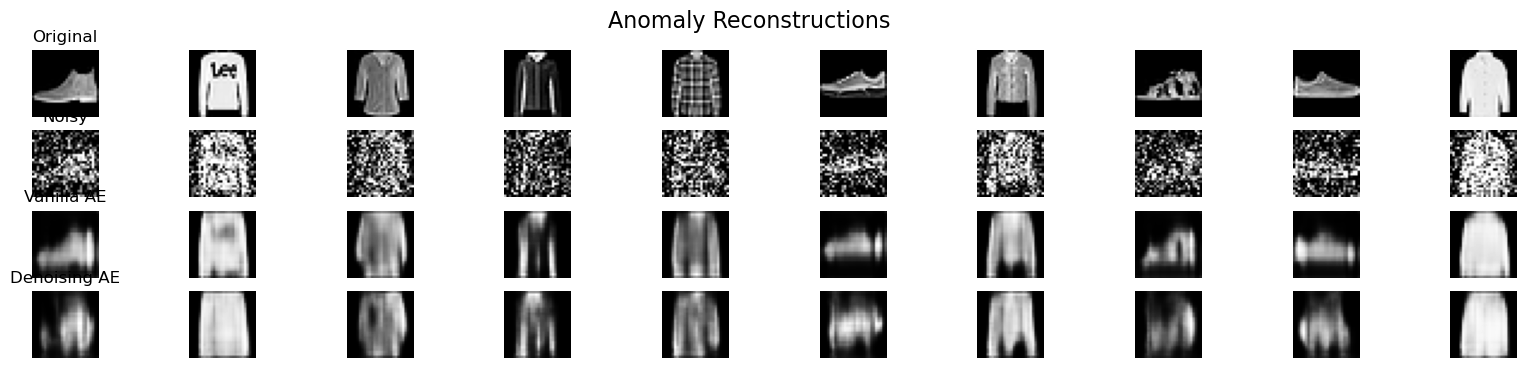

In [ ]:
plot_anomalies(x_test, x_test_noisy, vanilla_reconstructed, denoised_reconstructed,
               vanilla_errors, denoised_errors, vanilla_thresh, denoised_thresh, n=10)

### VAE Autoencoders

In [ ]:
class Sampling(keras.layers.Layer):
    def __init__(self, seed=1337, **kwargs):
        super().__init__(**kwargs)
        self.seed = seed

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim), seed=self.seed)
        sampled = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return tf.convert_to_tensor(sampled)

class KLDivergenceLayer(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * ops.mean(1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        self.add_loss(kl_loss)
        return None  # Do not return inputs to avoid potential cycles

def build_conv_vae(input_shape=(28, 28, 1), latent_dim=16):
    # Encoder
    encoder_inputs = keras.Input(shape=input_shape, name="encoder_input")
    x = keras.layers.Conv2D(32, 3, padding="same", activation="relu")(encoder_inputs)
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.Flatten()(x)

    z_mean = keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = keras.layers.Dense(latent_dim, name="z_log_var")(x)

    # Compute KL loss via custom layer, but don't capture the output
    KLDivergenceLayer()([z_mean, z_log_var])

    # Use the original z_mean and z_log_var for sampling
    z = Sampling()([z_mean, z_log_var])

    # Decoder
    decoder_inputs = keras.Input(shape=(latent_dim,), name="decoder_input")
    x = keras.layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
    x = keras.layers.Reshape((7, 7, 64))(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    decoder_outputs = keras.layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)

    decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
    vae_outputs = decoder(z)
    vae_model = keras.Model(encoder_inputs, vae_outputs, name="VAE")

    return vae_model

In [ ]:
# Build and summarize the model
vae_model = build_conv_vae()
vae_model.compile(optimizer='adam', loss='binary_crossentropy')
vae_model.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)    │ (None, 28, 28, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 28, 28, 32)        │             320 │ encoder_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 14, 14, 32)        │               0 │ conv2d_10[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 14, 14, 64)        │          18,496 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 7, 7, 64)          │               0 │ conv2d_11[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 3136)              │               0 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 16)                │          50,192 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_var (Dense)             │ (None, 16)                │          50,192 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sampling (Sampling)           │ (None, 16)                │               0 │ z_mean[0][0],              │
│                               │                           │                 │ z_log_var[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder (Functional)          │ (None, 28, 28, 1)         │         108,993 │ sampling[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 228,193 (891.38 KB)

 Trainable params: 228,193 (891.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
denoising_vae_model = build_conv_ae()
denoising_vae_model.compile(optimizer='adam', loss='binary_crossentropy')
denoising_vae_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 14, 14, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 7, 7, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the VAE on MNIST
print("Training VAE...")
vae_history = vae_model.fit(
    x_train, x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test),
    verbose=1
)

Training VAE...
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - loss: 0.4531 - val_loss: 0.5111
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - loss: 0.2434 - val_loss: 0.5207
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 324ms/step - loss: 0.2294 - val_loss: 0.4956
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 304ms/step - loss: 0.2157 - val_loss: 0.4759
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 306ms/step - loss: 0.2008 - val_loss: 0.4272
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 308ms/step - loss: 0.1921 - val_loss: 0.4128
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 319ms/step - loss: 0.1890 - val_loss: 0.4028
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - loss: 0.1870 - val_loss: 0.3928
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - loss: 0.1850 - val_loss: 0.3849
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 311ms/step - loss: 0.1844 - val_loss: 0.3759


In [ ]:
# Train Denoising AE
print("Training Denoising AE...")
denoising_history = denoising_vae_model.fit(
    x_train_noisy, x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_noisy, x_test),
    verbose=1
)

Training Denoising AE...
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.6149 - val_loss: 0.4951
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.3137 - val_loss: 0.4356
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.2545 - val_loss: 0.4329
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.2300 - val_loss: 0.4144
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.2189 - val_loss: 0.3973
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.2148 - val_loss: 0.3895
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.2120 - val_loss: 0.3827
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.2087 - val_loss: 0.3798
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.2067 - val_loss: 0.3754
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.2055 - val_loss: 0.3734


In [ ]:
# to plot original, noisy, and reconstructed images
def plot_reconstructions(original, noisy, vanilla_recon, denoised_recon, n=10):
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # Original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Noisy
        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Noisy')

        # Vanilla AE
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(vanilla_recon[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Recon VAE')

        # Denoising AE
        ax = plt.subplot(4, n, i + 1 + 3*n)
        plt.imshow(denoised_recon[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Denoising VAE')

    plt.show()

In [ ]:
# Get reconstructions
vae_reconstructed = vae_model.predict(x_test)
denoised_vae_reconstructed = denoising_vae_model.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


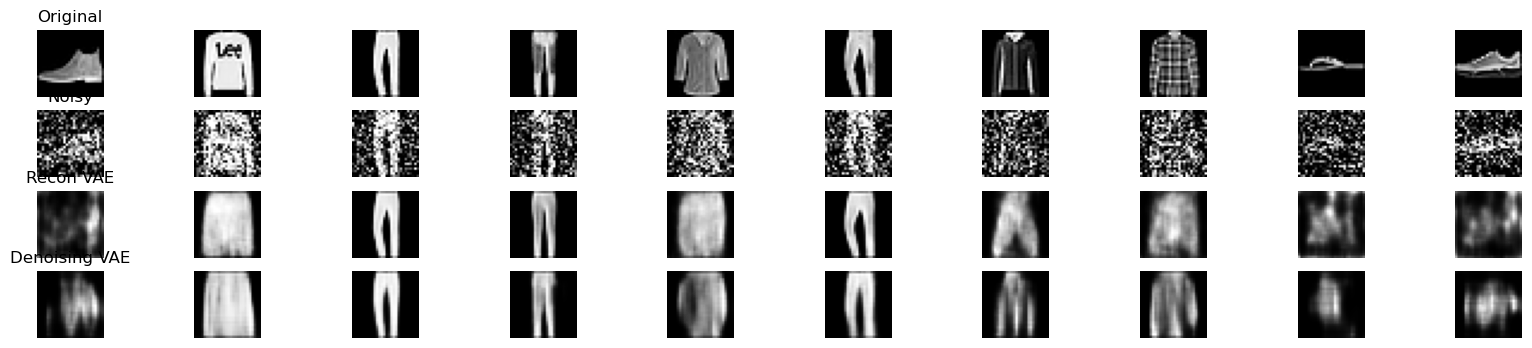

In [ ]:
# Plot results
plot_reconstructions(x_test, x_test_noisy, vae_reconstructed, denoised_vae_reconstructed)

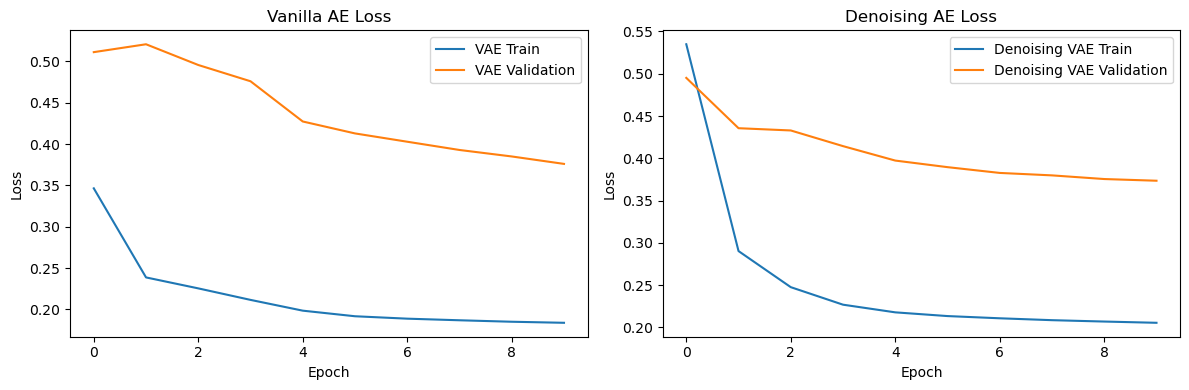

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(vae_history.history['loss'], label='VAE Train')
plt.plot(vae_history.history['val_loss'], label='VAE Validation')
plt.title('Vanilla AE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(denoising_history.history['loss'], label='Denoising VAE Train')
plt.plot(denoising_history.history['val_loss'], label='Denoising VAE Validation')
plt.title('Denoising AE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# VAE
vae_errors = np.mean((x_test - vae_reconstructed) ** 2, axis=(1, 2, 3))
compute_auroc(vae_errors, true_labels, model_name="VAE")

# Denoised VAE
denoised_vae_errors = np.mean((x_test - denoised_vae_reconstructed) ** 2, axis=(1, 2, 3))
compute_auroc(denoised_vae_errors, true_labels, model_name="Denoised VAE")

VAE AUROC: 0.9858
Denoised VAE AUROC: 0.9657


0.9656766666666666

### Anamoly detection VAE

In [ ]:
# After predictions
vanilla_train_reconstructed = vanilla_ae.predict(x_train)
denoised_train_reconstructed = denoising_ae.predict(x_train_noisy)

# Reconstruction errors
vanilla_errors = np.mean((x_test - vanilla_reconstructed) ** 2, axis=(1, 2, 3))
denoised_errors = np.mean((x_test - denoised_reconstructed) ** 2, axis=(1, 2, 3))

# Thresholds (based on training data)
vanilla_thresh = np.mean(vanilla_train_errors) + 3 * np.std(vanilla_train_errors)
denoised_thresh = np.mean(denoised_train_errors) + 3 * np.std(denoised_train_errors)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [ ]:
# Compare with threshold
vanilla_anomalies = vanilla_errors > vanilla_thresh
denoised_anomalies = denoised_errors > denoised_thresh

print(f"Vanilla AE detected {np.sum(vanilla_anomalies)} anomalies out of {len(x_test)}")
print(f"Denoising AE detected {np.sum(denoised_anomalies)} anomalies out of {len(x_test)}")

Vanilla AE detected 6794 anomalies out of 10000
Denoising AE detected 6474 anomalies out of 10000


In [ ]:
def plot_anomalies(original, noisy, vanilla_recon, denoised_recon, vanilla_errors, denoised_errors,
                   vanilla_thresh, denoised_thresh, n=10):
    import matplotlib.pyplot as plt
    import numpy as np

    # Detect anomalies
    vanilla_anomalies = vanilla_errors > vanilla_thresh
    denoised_anomalies = denoised_errors > denoised_thresh

    # Find combined anomalies (either detected)
    combined_anomalies = np.logical_or(vanilla_anomalies, denoised_anomalies)
    anomaly_indices = np.where(combined_anomalies)[0][:n]  # Limit to n samples

    if len(anomaly_indices) == 0:
        print("No anomalies found based on current thresholds.")
        return

    # Plotting
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(anomaly_indices):
        # Original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(original[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Noisy
        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(noisy[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Noisy')

        # Vanilla AE
        ax = plt.subplot(4, n, i + 1 + 2 * n)
        plt.imshow(vanilla_recon[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Vanilla AE')

        # Denoising AE
        ax = plt.subplot(4, n, i + 1 + 3 * n)
        plt.imshow(denoised_recon[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Denoising AE')

    plt.suptitle("Anomaly Reconstructions", fontsize=16)
    plt.show()


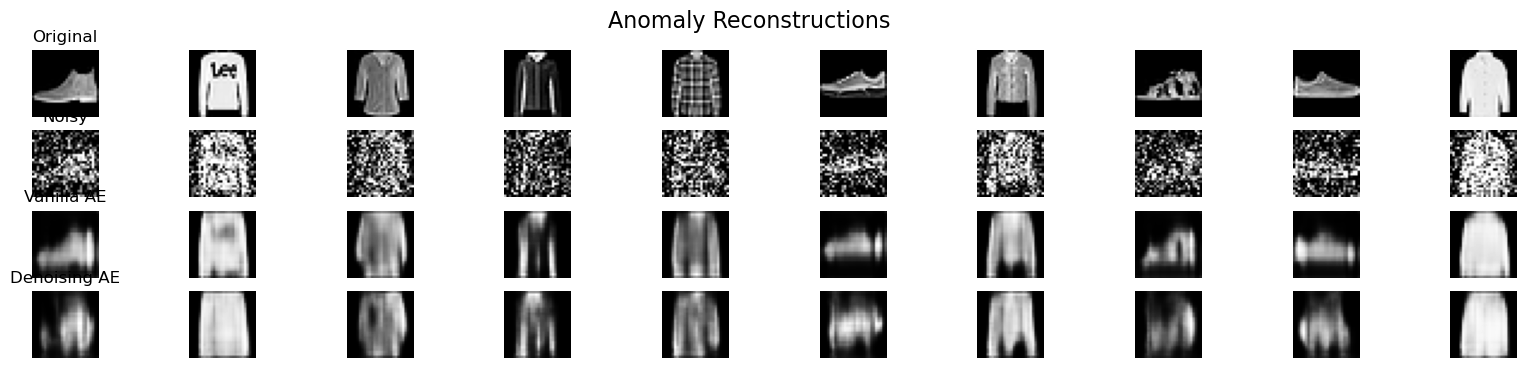

In [ ]:
plot_anomalies(x_test, x_test_noisy, vanilla_reconstructed, denoised_reconstructed,
               vanilla_errors, denoised_errors, vanilla_thresh, denoised_thresh, n=10)